# Neural machine translation with attention

이 노트북은 스페인어에서 영어로의 번역을 위해 sequence to sequence (seq2seq) 모델을 학습시킵니다. 이것은 시퀀스 모델에 대한 약간의 지식을 가정하는 고급 예제입니다.

이 노트북에서 모델을 학습 한 후 "¿ todavia estan en casa?" 와 같은 스페인어 문장을 입력 할 수 있습니다. , 영어 번역 : "아직 집에 계십니까?"

번역 품질은 장난감 예제에 합리적이지만 생성 된주의 플롯이 더 흥미로울 수 있습니다. 이것은 번역하는 동안 입력 문장의 어떤 부분이 모델의주의를 끌 었는지 보여줍니다.

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

http://www.manythings.org/anki/ 
에서 제공하는 언어 데이터 세트를 사용합니다 . 이 데이터 세트에는 다음 형식의 언어 번역 쌍이 포함되어 있습니다.

사용 가능한 다양한 언어가 있지만 영어-스페인어 데이터 세트를 사용합니다. 편의를 위해 Google Cloud에서이 데이터 세트의 사본을 호스팅했지만 자체 사본을 다운로드 할 수도 있습니다. 데이터 세트를 다운로드 한 후 데이터를 준비하기 위해 취할 단계는 다음과 같습니다.



1.   각 문장에 시작 및 종료 토큰을 추가하십시오.
2.   특수 문자를 제거하여 문장을 정리하십시오.
3. 단어 색인과 역방향 단어 색인을 만듭니다 (단어 → ID 및 ID → 단어에서 매핑 된 사전).
4. 각 문장을 최대 길이로 채 웁니다.

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [ ]:
# unicode file을 ascii로 변환
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')

    return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 더 빠르게 실험 할 수 있도록 데이터 세트 크기 제한 (선택 사항)


100,000 개 이상의 문장으로 구성된 전체 데이터 세트에 대한 훈련은 오랜 시간이 걸립니다. 더 빠르게 학습하기 위해 데이터 세트의 크기를 30,000 개의 문장으로 제한 할 수 있습니다 (물론 더 적은 데이터로 번역 품질이 저하됨).

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
target_tensor.shape

(30000, 11)

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> tom
16 ----> esta
173 ----> listo
71 ----> para
1033 ----> pelear
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
8 ----> is
182 ----> ready
15 ----> to
539 ----> fight
3 ----> .
2 ----> <end>


### tf.data 데이터 세트 만들기

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1 #PAD
vocab_tar_size = len(targ_lang.word_index)+1 #PAD

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 및 디코더 모델 작성
TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt).  에서 읽을 수있는주의를 기울여 인코더-디코더 모델을 구현합니다. 이 예에서는 최신 API 세트를 사용합니다. 이 노트북은 seq2seq 튜토리얼의 [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) 을 구현합니다. 다음 다이어그램은 각 입력 단어에주의 메커니즘에 의해 가중치가 할당 된 다음 디코더가 문장의 다음 단어를 예측하는 데 사용하는 것을 보여줍니다. 아래 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5) 에서 나온주의 메커니즘의 예입니다. 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

입력은 모양의 인코더 출력 (batch_size, max_length, hidden_size) 과 모양의 인코더 숨김 상태 (batch_size, hidden_size) 를 제공하는 인코더 모델을 통해 입력됩니다.

구현되는 방정식은 다음과 같습니다.:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

이 자습서에서는 인코더에 [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) 를 사용합니다. 단순화 된 형식을 작성하기 전에 표기법을 결정합시다.:

* FC = 완전 연결 (밀집) 계층
* EO = 엔코더 출력
* H = 숨겨진 상태
* X = 디코더에 대한 입력

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. 기본적으로 Softmax는 마지막 축에 적용되지만 여기서는 점수의 모양이 (batch_size, max_length, hidden_size) 이므로 첫 번째 축 에 적용하려고합니다.  `Max_length` 는 입력의 길이입니다. 각 입력에 가중치를 할당하려고하므로 해당 축에 소프트 맥스를 적용해야합니다.
* `context vector = sum(attention weights * EO, axis = 1)`. 축을 1로 선택한 위와 같은 이유입니다.
* `embedding output` = 디코더 X에 대한 입력은 임베딩 레이어를 통해 전달됩니다.
* `merged vector = concat(embedding output, context vector)`
* 이 병합 된 벡터는 GRU에 제공됩니다.

각 단계의 모든 벡터 모양은 코드의 주석에 지정되어 있습니다.:

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 옵티 마이저 및 손실 함수 정의




In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 체크 포인트 (객체 기반 저장)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. 인코더 출력 과 인코더 숨김 상태 를 반환하는 인코더 를 통해 입력을 전달합니다.
2. 인코더 출력, 인코더 숨김 상태 및 디코더 입력 ( 시작 토큰 )
3. 이 디코더로 전달됩니다.
4. 디코더는 예측 과 디코더 숨김 상태를 반환합니다.
그런 다음 디코더 숨김 상태가 모델로 다시 전달되고 예측이 손실을 계산하는 데 사용됩니다.
5. 디코더에 대한 다음 입력을 결정하기 위해 교사 강제 를 사용합니다.
6. 교사 강제 는 대상 단어 가 디코더의 다음 입력 으로 전달되는 기술입니다.
7. 마지막 단계는 그래디언트를 계산하고이를 옵티 마이저에 적용하고 역 전파하는 것입니다.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step(inp, targ, enc_hidden)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                    batch,
                                                    batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8197
Epoch 1 Batch 100 Loss 2.1930
Epoch 1 Batch 200 Loss 1.8001
Epoch 1 Batch 300 Loss 1.7152
Epoch 1 Loss 2.0543
Time taken for 1 epoch 45.059884548187256 sec

Epoch 2 Batch 0 Loss 1.5385
Epoch 2 Batch 100 Loss 1.5347
Epoch 2 Batch 200 Loss 1.4028
Epoch 2 Batch 300 Loss 1.2978
Epoch 2 Loss 1.4039
Time taken for 1 epoch 34.797964096069336 sec

Epoch 3 Batch 0 Loss 1.2628
Epoch 3 Batch 100 Loss 0.9570
Epoch 3 Batch 200 Loss 0.9309
Epoch 3 Batch 300 Loss 0.9460
Epoch 3 Loss 0.9739
Time taken for 1 epoch 34.310510873794556 sec

Epoch 4 Batch 0 Loss 0.6672
Epoch 4 Batch 100 Loss 0.6684
Epoch 4 Batch 200 Loss 0.6470
Epoch 4 Batch 300 Loss 0.6398
Epoch 4 Loss 0.6554
Time taken for 1 epoch 34.68235111236572 sec

Epoch 5 Batch 0 Loss 0.4548
Epoch 5 Batch 100 Loss 0.4001
Epoch 5 Batch 200 Loss 0.4965
Epoch 5 Batch 300 Loss 0.4076
Epoch 5 Loss 0.4437
Time taken for 1 epoch 34.28078103065491 sec

Epoch 6 Batch 0 Loss 0.2568
Epoch 6 Batch 100 Loss 0.3502
Epoch 6 Batch 200 L

## Translate

* 평가 기능은 여기서 교사 강제력을 사용하지 않는다는 점을 제외하면 훈련 루프와 유사합니다. 
* 각 시간 단계에서 디코더에 대한 입력은 숨겨진 상태 및 인코더 출력과 함께 이전 예측입니다.
* 모델이 종료 토큰을 예측할 때 예측을 중지합니다.
* 그리고 모든 시간 단계에 대한주의 가중치를 저장합니다.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_inp,
                                                          padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
      predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()

      predicted_id = tf.argmax(predictions[0]).numpy()

      result += targ_lang.index_word[predicted_id] + ' '

      if targ_lang.index_word[predicted_id] == '<end>':
        return result, sentence, attention_plot

      # the predicted ID is fed back into the model
      dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    print(attention)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 최신 체크 포인트 복원 및 테스트

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


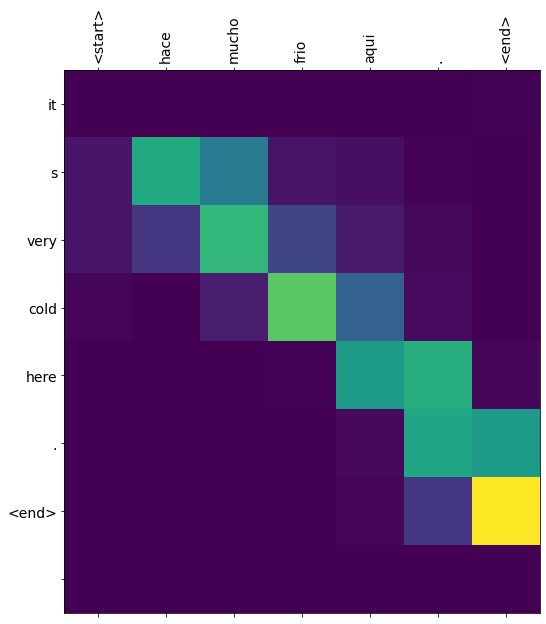

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


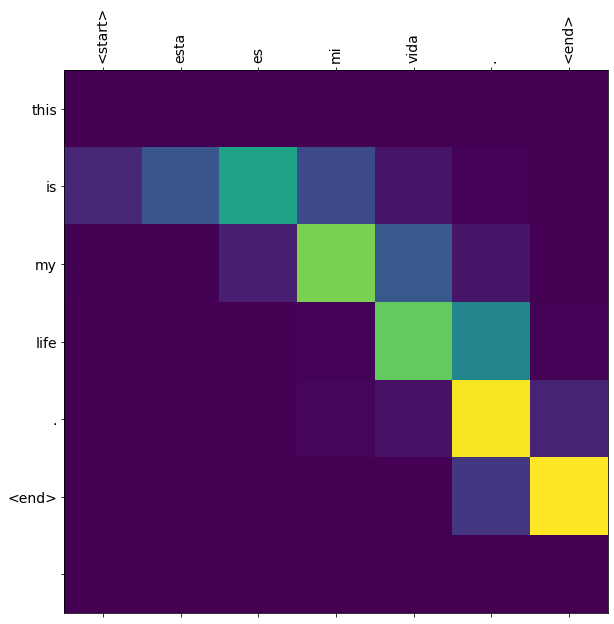

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


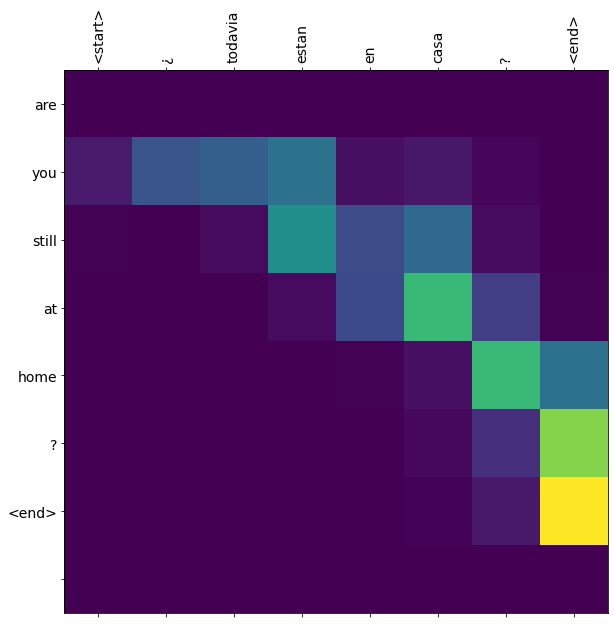

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 
[[2.26711716e-09 1.16427330e-08 1.14630566e-05 4.15272698e-05
  1.27303414e-04 2.82605691e-03]
 [2.67945807e-02 3.42381060e-01 2.30190203e-01 3.74176145e-01
  2.37073898e-02 8.82734428e-04]
 [3.70960915e-03 9.54249129e-03 9.01641399e-02 5.84125221e-01
  2.91290015e-01 9.29766335e-03]
 [5.19735366e-03 6.17256993e-03 2.22592037e-02 1.82030126e-01
  7.44728029e-01 2.49140095e-02]
 [1.37084979e-03 1.54689536e-03 1.67056080e-02 6.44879118e-02
  7.69130349e-01 1.30764797e-01]
 [1.57249378e-05 1.72288455e-05 4.22564161e-04 1.36038428e-03
  2.48071507e-01 7.29656279e-01]
 [6.44213787e-06 9.53355539e-06 5.64403781e-05 1.42007921e-04
  7.61452969e-03 9.79295611e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


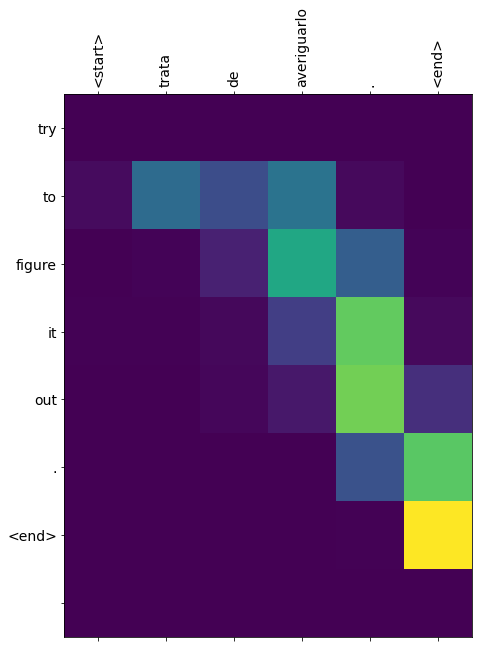

In [ ]:
# wrong translation
translate(u'trata de averiguarlo.')